In [32]:
import pandas as pd
import numpy as np
import librosa
import os
from tqdm import tqdm

# Configuration
SR = 16000 
MAX_LEN = 5 * SR 
DATA_DIR = 'dataset' # Make sure this matches your folder path
SAVE_DIR = 'processed_data/'

# Create save directory if it doesn't exist
os.makedirs(SAVE_DIR, exist_ok=True)

def load_segment_and_save(data_dir, save_dir):
    audio_data = []
    labels = []
    metadata = [] # List to store CSV rows
    
    # Get list of text files
    files = [f for f in os.listdir(data_dir) if f.endswith('.txt')]
    print(f"Found {len(files)} annotation files.")
    
    for txt_file in tqdm(files):
        prefix = txt_file.split('.')[0]
        wav_file = os.path.join(data_dir, prefix + '.wav')
        
        # Safety Check: Ensure WAV exists
        if not os.path.exists(wav_file):
            continue
            
        try:
            # Load Audio
            y_signal, _ = librosa.load(wav_file, sr=SR)
            
            # Load Annotations
            annotations = pd.read_csv(os.path.join(data_dir, txt_file), 
                                      sep='\t', header=None, names=['start', 'end', 'crackle', 'wheeze'])
            
            for index, row in annotations.iterrows():
                start_sample = int(row['start'] * SR)
                end_sample = int(row['end'] * SR)
                
                # Label Logic
                if row['crackle'] == 0 and row['wheeze'] == 0:
                    label = 'Normal'
                elif row['crackle'] == 1 and row['wheeze'] == 0:
                    label = 'Crackle'
                elif row['crackle'] == 0 and row['wheeze'] == 1:
                    label = 'Wheeze'
                else:
                    continue # Skip 'Both' class
                
                # Check bounds
                if end_sample > len(y_signal): end_sample = len(y_signal)
                
                segment = y_signal[start_sample:end_sample]
                
                # Skip artifacts (too short)
                if len(segment) < 512: continue

                # Pad/Truncate
                if len(segment) > MAX_LEN:
                    segment = segment[:MAX_LEN]
                else:
                    pad_width = MAX_LEN - len(segment)
                    segment = np.pad(segment, (0, pad_width), mode='constant')
                    
                # Append Data
                audio_data.append(segment)
                labels.append(label)
                
                # Append Metadata for CSV
                metadata.append({
                    'filename': prefix,
                    'start_time': row['start'],
                    'end_time': row['end'],
                    'label': label,
                    'sample_rate': SR
                })
                
        except Exception as e:
            print(f"Error processing {txt_file}: {e}")
            continue

    # Convert to Numpy Arrays
    X = np.array(audio_data)
    y = np.array(labels)
    
    # --- SAVE TO DISK ---
    
    # 1. Save Metadata to CSV
    df = pd.DataFrame(metadata)
    csv_path = os.path.join(save_dir, 'dataset_metadata.csv')
    df.to_csv(csv_path, index=False)
    print(f"✅ Metadata saved to: {csv_path}")
    
    # 2. Save Audio Arrays to .npy (Efficient)
    np.save(os.path.join(save_dir, 'X_data.npy'), X)
    np.save(os.path.join(save_dir, 'y_data.npy'), y)
    print(f"✅ Arrays saved to: {save_dir} (X shape: {X.shape})")
            
    return X, y, df

# --- EXECUTE ---
X, y, df_metadata = load_segment_and_save(DATA_DIR, SAVE_DIR)

# Optional: View first few rows
print("\nFirst 5 rows of generated CSV:")
print(df_metadata.head())

Found 193 annotation files.


100%|██████████| 193/193 [00:00<00:00, 325.86it/s]


✅ Metadata saved to: processed_data/dataset_metadata.csv
✅ Arrays saved to: processed_data/ (X shape: (829, 80000))

First 5 rows of generated CSV:
                 filename  start_time  end_time   label  sample_rate
0  104_1b1_Al_sc_Litt3200      0.0000    1.8771  Normal        16000
1  104_1b1_Al_sc_Litt3200      1.8771    3.7543  Normal        16000
2  104_1b1_Al_sc_Litt3200      3.7543    6.1071  Normal        16000
3  104_1b1_Al_sc_Litt3200      6.1071    8.2502  Normal        16000
4  104_1b1_Al_sc_Litt3200      8.2502   12.6180  Normal        16000


In [38]:
import numpy as np
import pandas as pd
import librosa
import os
from sklearn.utils import resample
from tqdm import tqdm

# Configuration
SAVE_DIR = './processed_data/'
SR = 16000
MAX_LEN = 5 * SR

def augment_and_save_balanced_data(save_dir):
    print("Loading clean data...")
    X = np.load(os.path.join(save_dir, 'X_data.npy'))
    y = np.load(os.path.join(save_dir, 'y_data.npy'))
    df = pd.read_csv(os.path.join(save_dir, 'dataset_metadata.csv'))
    
    # 1. Check Distributions
    unique, counts = np.unique(y, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print(f"Original Counts: {class_counts}")
    
    # Target count = count of the majority class (usually 'Normal')
    target_count = max(counts)
    print(f"Target count per class: {target_count}")
    
    X_aug_list = []
    y_aug_list = []
    meta_aug_list = []
    
    # 2. Loop through each class to balance
    for label in unique:
        # Get indices of this class
        indices = np.where(y == label)[0]
        class_X = X[indices]
        class_y = y[indices]
        class_df = df.iloc[indices]
        
        # Calculate how many we need to generate
        current_count = len(class_X)
        needed = target_count - current_count
        
        # Add originals to list first
        X_aug_list.extend(class_X)
        y_aug_list.extend(class_y)
        meta_aug_list.extend(class_df.to_dict('records'))
        
        if needed > 0:
            print(f"Augmenting class '{label}': Generating {needed} new samples...")
            
            # Resample indices to pick random samples to augment
            aug_indices = resample(indices, n_samples=needed, replace=True)
            
            for idx in tqdm(aug_indices):
                # Get audio to augment
                original_audio = X[idx]
                original_meta = df.iloc[idx].to_dict()
                
                # --- APPLY AUGMENTATION (Speed Perturbation) ---
                rate = np.random.uniform(0.8, 1.2) # Speed up or slow down
                aug_audio = librosa.effects.time_stretch(original_audio, rate=rate)
                
                # Fix length (must match CNN input size)
                if len(aug_audio) > MAX_LEN:
                    aug_audio = aug_audio[:MAX_LEN]
                else:
                    pad_width = MAX_LEN - len(aug_audio)
                    aug_audio = np.pad(aug_audio, (0, pad_width), mode='constant')
                
                # Add to lists
                X_aug_list.append(aug_audio)
                y_aug_list.append(label)
                
                # Update Metadata for CSV
                new_meta = original_meta.copy()
                new_meta['filename'] = f"aug_{original_meta['filename']}"
                new_meta['augmentation'] = f"speed_{rate:.2f}"
                meta_aug_list.append(new_meta)
                
    # 3. Convert to Arrays
    X_balanced = np.array(X_aug_list)
    y_balanced = np.array(y_aug_list)
    df_balanced = pd.DataFrame(meta_aug_list)
    
    print("\nFinal Balanced Counts:")
    unique, counts = np.unique(y_balanced, return_counts=True)
    print(dict(zip(unique, counts)))
    
    # 4. Save Balanced Dataset
    np.save(os.path.join(save_dir, 'X_augmented.npy'), X_balanced)
    np.save(os.path.join(save_dir, 'y_augmented.npy'), y_balanced)
    df_balanced.to_csv(os.path.join(save_dir, 'dataset_metadata_augmented.csv'), index=False)
    
    print(f"✅ Balanced dataset saved to {save_dir}")
    return X_balanced, y_balanced

# --- Run Phase 3 ---
X_aug, y_aug = augment_and_save_balanced_data(SAVE_DIR)

Loading clean data...
Original Counts: {np.str_('Crackle'): np.int64(242), np.str_('Normal'): np.int64(449), np.str_('Wheeze'): np.int64(138)}
Target count per class: 449
Augmenting class 'Crackle': Generating 207 new samples...


100%|██████████| 207/207 [00:05<00:00, 37.25it/s]


Augmenting class 'Wheeze': Generating 311 new samples...


100%|██████████| 311/311 [00:04<00:00, 76.71it/s]



Final Balanced Counts:
{np.str_('Crackle'): np.int64(449), np.str_('Normal'): np.int64(449), np.str_('Wheeze'): np.int64(449)}
✅ Balanced dataset saved to ./processed_data/


In [49]:
import numpy as np
import pandas as pd
import librosa
import os

# Configuration
LOAD_DIR = './processed_data/'
SAVE_DIR = './processed_data/'  # We will save features here too

# --- 1. Load Raw Augmented Audio ---
print("Loading raw augmented audio...")
try:
    X_raw = np.load(os.path.join(LOAD_DIR, 'X_augmented.npy'))
    y_raw = np.load(os.path.join(LOAD_DIR, 'y_augmented.npy'))
except FileNotFoundError:
    print("Error: Could not find 'X_augmented.npy'. Please run Phase 3 first.")
    exit()

# --- 2. Define Normalization Function ---
def extract_features_normalized(audio_data):
    spectrograms = []
    print(f"Extracting features from {len(audio_data)} samples...")
    
    for i, signal in enumerate(audio_data):
        # Progress indicator every 500 samples
        if i % 500 == 0: print(f"Processing sample {i}...")
            
        signal = np.squeeze(signal)
        
        # STFT (Short-Time Fourier Transform)
        stft = librosa.stft(signal, n_fft=2048, hop_length=512)
        spectrogram = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        
        # --- CRITICAL: Min-Max Normalization (0 to 1) ---
        # This fixes the "Model Collapse" issue
        norm_spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())
        
        # Reshape for CNN input (Freq, Time, 1)
        norm_spectrogram = norm_spectrogram[..., np.newaxis] 
        spectrograms.append(norm_spectrogram)
        
    return np.array(spectrograms)

# --- 3. Run Extraction ---
X_feats = extract_features_normalized(X_raw)

print(f"\nFeature Shape: {X_feats.shape}")
print(f"Data Range: {X_feats.min():.2f} to {X_feats.max():.2f}")

# --- 4. Save to Disk ---
print("\nSaving features to disk...")

# Save X (Images) as .npy (Efficient)
np.save(os.path.join(SAVE_DIR, 'features_X.npy'), X_feats)

# Save y (Labels) as .csv (Readable)
df_labels = pd.DataFrame(y_raw, columns=['label'])
df_labels.to_csv(os.path.join(SAVE_DIR, 'labels_y.csv'), index=False)

print(f"✅ Success! \nImages saved to: {os.path.join(SAVE_DIR, 'features_X.npy')}\nLabels saved to: {os.path.join(SAVE_DIR, 'labels_y.csv')}")

Loading raw augmented audio...
Extracting features from 1347 samples...
Processing sample 0...
Processing sample 500...
Processing sample 1000...

Feature Shape: (1347, 1025, 157, 1)
Data Range: 0.00 to 1.00

Saving features to disk...
✅ Success! 
Images saved to: ./processed_data/features_X.npy
Labels saved to: ./processed_data/labels_y.csv


In [50]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_hybrid_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # --- CNN Block ---
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # --- Reshape for LSTM ---
    # We squash Frequency and Channels, keeping Time as the sequence dimension
    # Shape logic: (Batch, Freq, Time, Filters) -> (Batch, Time, Freq * Filters)
    target_shape = (x.shape[2], x.shape[1] * x.shape[3])
    x = layers.Reshape(target_shape)(x)
    
    # --- LSTM Block ---
    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.Dropout(0.5)(x)
    
    # --- Classification Head ---
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name="Hybrid_CNN_LSTM")
    return model

# Instantiate
model = build_hybrid_model(input_shape=X_feats.shape[1:], num_classes=3)
model.summary()

Model: "Hybrid_CNN_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1025, 157, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 1025, 157, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 512, 78, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512, 78, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 512, 78, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 256, 39, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256, 39, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 256, 39, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 128, 19, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 19, 16384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │     4,210,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,304,195 (16.42 MB)

 Trainable params: 4,304,003 (16.42 MB)

 Non-trainable params: 192 (768.00 B)

In [51]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import os

# --- 1. Load Pre-Computed Features ---
DATA_DIR = './processed_data/'

print("Loading dataset from disk...")
# Load Images
X_feats = np.load(os.path.join(DATA_DIR, 'features_X.npy'))

# Load Labels from CSV
df_labels = pd.read_csv(os.path.join(DATA_DIR, 'labels_y.csv'))
y_labels = df_labels['label'].values

print(f"Loaded {len(X_feats)} samples.")

# --- 2. Encode Labels ---
le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y_labels))
print(f"Classes: {le.classes_}")

# --- 3. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(X_feats, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# --- 4. Compile Model (Low Learning Rate) ---
# Assuming 'model' is already built using your build_hybrid_model function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # Lower LR to prevent collapse

model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# --- 5. Train ---
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
]

print("Starting training...")
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=50, 
                    batch_size=32, 
                    shuffle=True, 
                    callbacks=callbacks)

Loading dataset from disk...
Loaded 1347 samples.
Classes: ['Crackle' 'Normal' 'Wheeze']
Starting training...
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.3735 - loss: 1.1502 - precision_9: 0.3349 - recall_9: 0.1157

34/34 ━━━━━━━━━━━━━━━━━━━━ 29s 776ms/step - accuracy: 0.4039 - loss: 1.1123 - precision_9: 0.3841 - recall_9: 0.1170 - val_accuracy: 0.3333 - val_loss: 1.1022 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 745ms/step - accuracy: 0.4457 - loss: 1.0356 - precision_9: 0.6636 - recall_9: 0.1356 - val_accuracy: 0.3333 - val_loss: 1.1164 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 733ms/step - accuracy: 0.5209 - loss: 0.9820 - precision_9: 0.6032 - recall_9: 0.2442 - val_accuracy: 0.3333 - val_loss: 1.1862 - val_precision_9: 0.3333 - val_recall_9: 0.3333
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 734ms/step - accuracy: 0.5311 - loss: 0.9558 - precision_9: 0.6561 - recall_9: 0.3064 - val_accuracy: 0.3333 - val_loss: 1.3239 - val_precision_9: 0.3333 - val_recall_9: 0.3333
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 731ms/step - accuracy: 0.5701 - loss: 0.9114 - precision_9: 0.6879 - recall_9

34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 733ms/step - accuracy: 0.8858 - loss: 0.3485 - precision_9: 0.9134 - recall_9: 0.8617 - val_accuracy: 0.5741 - val_loss: 1.0801 - val_precision_9: 0.5851 - val_recall_9: 0.5222
Epoch 22/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 744ms/step - accuracy: 0.9006 - loss: 0.3121 - precision_9: 0.9156 - recall_9: 0.8765 - val_accuracy: 0.5296 - val_loss: 1.2641 - val_precision_9: 0.5510 - val_recall_9: 0.5000
Epoch 23/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9242 - loss: 0.2730 - precision_9: 0.9402 - recall_9: 0.9030

34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 740ms/step - accuracy: 0.9248 - loss: 0.2781 - precision_9: 0.9444 - recall_9: 0.8988 - val_accuracy: 0.5926 - val_loss: 0.9995 - val_precision_9: 0.6341 - val_recall_9: 0.5778
Epoch 24/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 745ms/step - accuracy: 0.9294 - loss: 0.2474 - precision_9: 0.9489 - recall_9: 0.9136 - val_accuracy: 0.6111 - val_loss: 1.0828 - val_precision_9: 0.6210 - val_recall_9: 0.5704
Epoch 25/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 736ms/step - accuracy: 0.9508 - loss: 0.2129 - precision_9: 0.9628 - recall_9: 0.9369 - val_accuracy: 0.5111 - val_loss: 1.4843 - val_precision_9: 0.5273 - val_recall_9: 0.5000
Epoch 26/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9547 - loss: 0.1791 - precision_9: 0.9633 - recall_9: 0.9400

34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 733ms/step - accuracy: 0.9536 - loss: 0.1876 - precision_9: 0.9648 - recall_9: 0.9406 - val_accuracy: 0.6444 - val_loss: 0.9291 - val_precision_9: 0.6667 - val_recall_9: 0.6222
Epoch 27/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 745ms/step - accuracy: 0.9712 - loss: 0.1522 - precision_9: 0.9765 - recall_9: 0.9638 - val_accuracy: 0.5630 - val_loss: 1.1513 - val_precision_9: 0.5748 - val_recall_9: 0.5407
Epoch 28/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 739ms/step - accuracy: 0.9768 - loss: 0.1285 - precision_9: 0.9803 - recall_9: 0.9703 - val_accuracy: 0.6407 - val_loss: 1.0038 - val_precision_9: 0.6522 - val_recall_9: 0.6111
Epoch 29/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.9655 - loss: 0.1531 - precision_9: 0.9721 - recall_9: 0.9610

34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 734ms/step - accuracy: 0.9647 - loss: 0.1474 - precision_9: 0.9736 - recall_9: 0.9601 - val_accuracy: 0.6407 - val_loss: 0.9225 - val_precision_9: 0.6680 - val_recall_9: 0.6259
Epoch 30/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 748ms/step - accuracy: 0.9861 - loss: 0.1043 - precision_9: 0.9888 - recall_9: 0.9833 - val_accuracy: 0.6222 - val_loss: 0.9780 - val_precision_9: 0.6328 - val_recall_9: 0.6000
Epoch 31/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 737ms/step - accuracy: 0.9824 - loss: 0.1170 - precision_9: 0.9859 - recall_9: 0.9712 - val_accuracy: 0.6259 - val_loss: 0.9861 - val_precision_9: 0.6496 - val_recall_9: 0.6111
Epoch 32/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 731ms/step - accuracy: 0.9731 - loss: 0.1125 - precision_9: 0.9784 - recall_9: 0.9675 - val_accuracy: 0.6407 - val_loss: 1.0317 - val_precision_9: 0.6575 - val_recall_9: 0.6185
Epoch 33/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 733ms/step - accuracy: 0.9898 - loss: 0.0827 - precision_9: 0.9916 - recall_9: 0.9879 - v

✅ Automatically detected target layer: 'conv2d_14'
Visualizing Test Sample Index: 114


C:\Users\User\anaconda3\envs\Yolo-GPU\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_52']]
Received: inputs=Tensor(shape=(1, 1025, 157, 1))
  warnings.warn(msg)


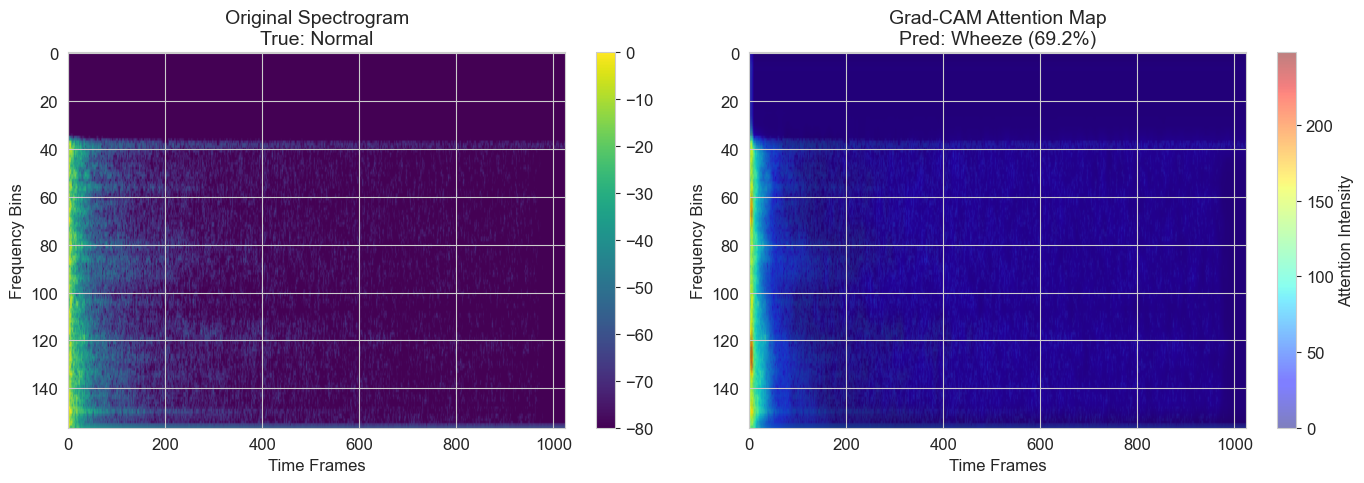

In [43]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2  # OpenCV for image resizing
import random

# --- 1. Helper: Auto-Detect the Last Convolutional Layer ---
def get_last_conv_layer_name(model):
    """
    Searches the model in reverse order to find the last Conv2D layer.
    This fixes the 'ValueError: No such layer' by finding the current name automatically.
    """
    for layer in reversed(model.layers):
        if 'conv2d' in layer.name:
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

# --- 2. Helper: Calculate the Heatmap ---
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute gradient of the top predicted class
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Global Average Pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map by its importance
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --- 3. Helper: Visualize the Result ---
def plot_gradcam(model, X_test, y_test, index, layer_name, class_names=['Normal', 'Crackle', 'Wheeze']):
    """
    Generates and plots the Grad-CAM heatmap overlay.
    """
    # Prepare the input image
    img_tensor = X_test[index][np.newaxis, ...] # Add batch dimension: (1, Freq, Time, 1)
    
    # Get the heatmap using the specific layer name
    try:
        heatmap = make_gradcam_heatmap(img_tensor, model, layer_name)
    except Exception as e:
        print(f"Error generating heatmap: {e}")
        return

    # Get Predictions
    true_label_idx = np.argmax(y_test[index])
    pred_probs = model.predict(img_tensor, verbose=0)
    pred_label_idx = np.argmax(pred_probs)
    confidence = np.max(pred_probs) * 100

    # --- Processing for Visualization ---
    # Get original spectrogram for plotting
    original_img = X_test[index].squeeze() # Shape: (Freq, Time)
    
    # Resize Heatmap to match original Spectrogram size
    # We use OpenCV (cv2) to zoom the small heatmap up to the full image size
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    
    # Convert heatmap to 0-255 range for coloring
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    
    # --- Plotting ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Original Spectrogram
    # Rot90 creates the standard Time (x) vs Freq (y) view
    im1 = axes[0].imshow(np.rot90(original_img), cmap='viridis', aspect='auto')
    axes[0].set_title(f"Original Spectrogram\nTrue: {class_names[true_label_idx]}", fontsize=14)
    axes[0].set_xlabel("Time Frames")
    axes[0].set_ylabel("Frequency Bins")
    plt.colorbar(im1, ax=axes[0])

    # Plot 2: Grad-CAM Overlay
    # Plot the background image
    axes[1].imshow(np.rot90(original_img), cmap='viridis', aspect='auto')
    # Overlay the heatmap (alpha sets transparency)
    im2 = axes[1].imshow(np.rot90(heatmap_uint8), cmap='jet', alpha=0.5, aspect='auto')
    
    axes[1].set_title(f"Grad-CAM Attention Map\nPred: {class_names[pred_label_idx]} ({confidence:.1f}%)", fontsize=14)
    axes[1].set_xlabel("Time Frames")
    axes[1].set_ylabel("Frequency Bins")
    plt.colorbar(im2, ax=axes[1], label='Attention Intensity')

    plt.tight_layout()
    plt.show()

# --- 4. EXECUTION ---

# Step A: Auto-detect the correct layer name
target_layer = get_last_conv_layer_name(model)
print(f"✅ Automatically detected target layer: '{target_layer}'")

# Step B: Pick a random sample and visualize
random_index = random.randint(0, len(X_test) - 1)
print(f"Visualizing Test Sample Index: {random_index}")

plot_gradcam(model, X_test, y_test, random_index, target_layer)

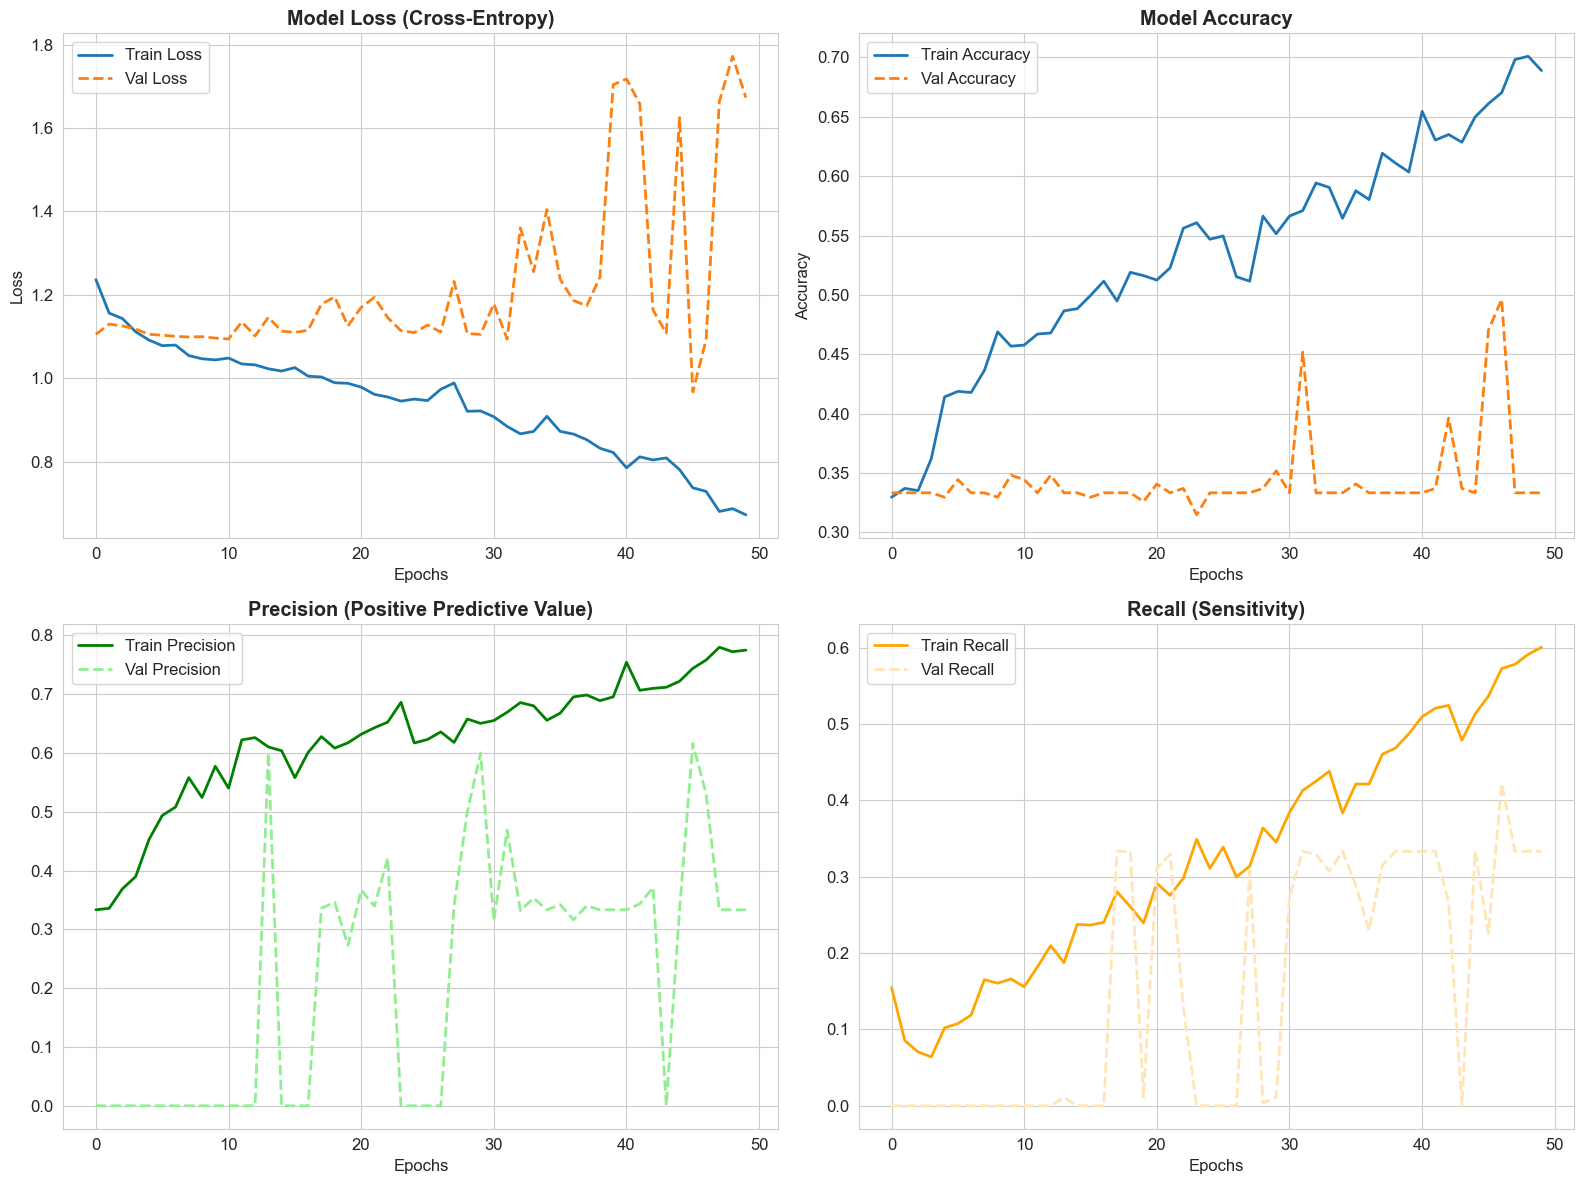

Generating predictions...
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


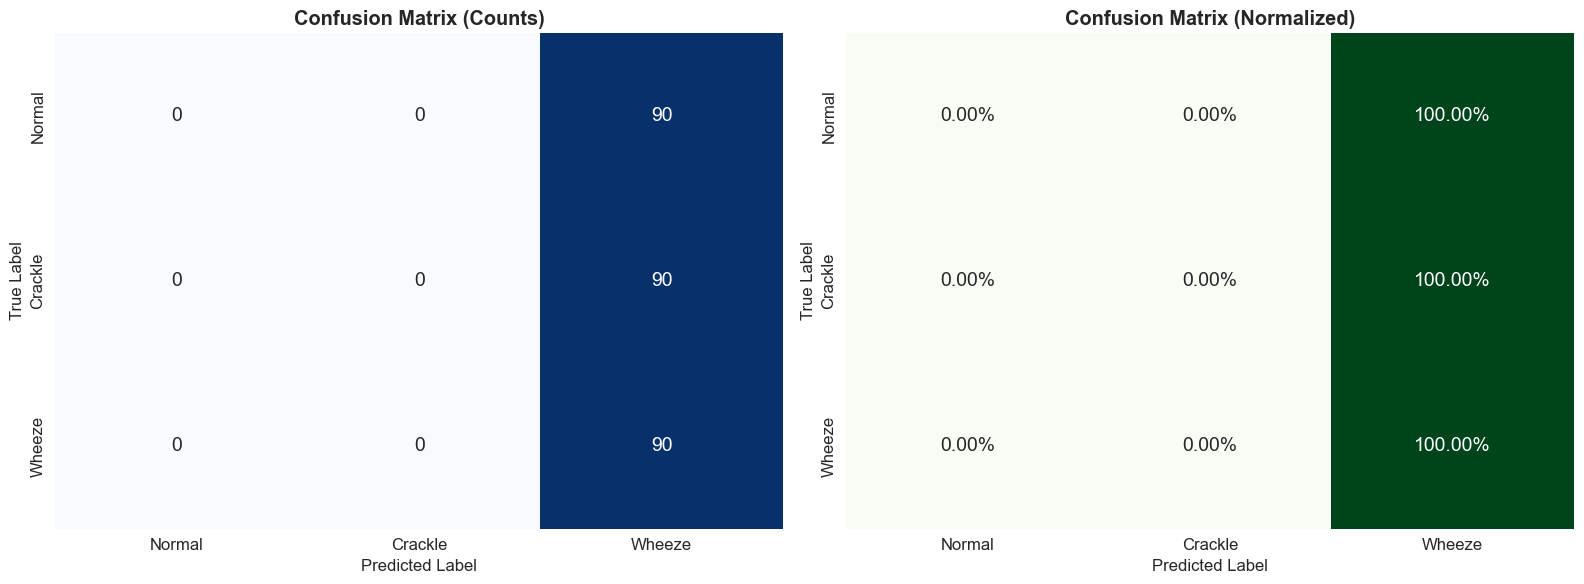


FINAL CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        90
     Crackle       0.00      0.00      0.00        90
      Wheeze       0.33      1.00      0.50        90

    accuracy                           0.33       270
   macro avg       0.11      0.33      0.17       270
weighted avg       0.11      0.33      0.17       270



C:\Users\User\anaconda3\envs\Yolo-GPU\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\User\anaconda3\envs\Yolo-GPU\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\User\anaconda3\envs\Yolo-GPU\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Set style for publication-quality plots
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

def plot_performance_suite(history, model, X_test, y_test, class_names=['Normal', 'Crackle', 'Wheeze']):
    """
    Generates a complete report of model performance:
    1. Training & Validation Curves (Loss, Accuracy, Precision, Recall)
    2. Confusion Matrix (Counts & Percentages)
    3. Classification Report
    """
    
    # --- 1. Dynamic Metric Plotting ---
    # Find the keys for precision and recall in the history object
    # (Keras sometimes names them 'precision', 'precision_1', etc.)
    keys = history.history.keys()
    prec_key = next((k for k in keys if 'precision' in k and 'val' not in k), None)
    rec_key = next((k for k in keys if 'recall' in k and 'val' not in k), None)

    # Determine layout: 2 columns, 1 or 2 rows depending on metrics
    rows = 2 if prec_key and rec_key else 1
    fig, axes = plt.subplots(rows, 2, figsize=(16, 6 * rows))
    axes = axes.flatten() if rows > 1 else axes

    # Plot Loss
    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2, linestyle='--')
    axes[0].set_title('Model Loss (Cross-Entropy)', fontweight='bold')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    # Plot Accuracy
    axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, linestyle='--')
    axes[1].set_title('Model Accuracy', fontweight='bold')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    # Plot Precision & Recall (if they exist)
    if rows > 1:
        # Precision
        axes[2].plot(history.history[prec_key], label='Train Precision', linewidth=2, color='green')
        axes[2].plot(history.history[f'val_{prec_key}'], label='Val Precision', linewidth=2, linestyle='--', color='lightgreen')
        axes[2].set_title('Precision (Positive Predictive Value)', fontweight='bold')
        axes[2].set_xlabel('Epochs')
        axes[2].legend()

        # Recall
        axes[3].plot(history.history[rec_key], label='Train Recall', linewidth=2, color='orange')
        axes[3].plot(history.history[f'val_{rec_key}'], label='Val Recall', linewidth=2, linestyle='--', color='moccasin')
        axes[3].set_title('Recall (Sensitivity)', fontweight='bold')
        axes[3].set_xlabel('Epochs')
        axes[3].legend()

    plt.tight_layout()
    plt.show()

    # --- 2. Confusion Matrices ---
    # Get predictions
    print("Generating predictions...")
    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Compute Raw Matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    
    # Compute Normalized Matrix (Percentages)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Raw Counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, 
                cbar=False, annot_kws={"size": 14}, ax=ax[0])
    ax[0].set_title('Confusion Matrix (Counts)', fontweight='bold')
    ax[0].set_ylabel('True Label')
    ax[0].set_xlabel('Predicted Label')

    # Percentages (Sensitivity)
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens', 
                xticklabels=class_names, yticklabels=class_names, 
                cbar=False, annot_kws={"size": 14}, ax=ax[1])
    ax[1].set_title('Confusion Matrix (Normalized)', fontweight='bold')
    ax[1].set_ylabel('True Label')
    ax[1].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

    # --- 3. Detailed Metrics ---
    print("\n" + "="*50)
    print("FINAL CLASSIFICATION REPORT")
    print("="*50)
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# --- Execute Performance Suite ---
plot_performance_suite(history, model, X_test, y_test)